This Python notebook complements our broader discussion on the challenges of handling personally identifiable information (PII) in educational datasets, as explored in our related blog post.

It showcases the ELECTRA (Efficiently Learning an Encoder that Classifies Token Replacements Accurately) model, which **emerged as the second-best model** in our assessments. In this notebook, we demonstrate the setup, training, and evaluation of the ELECTRA model, providing insights into its capabilities and effectiveness in PII detection and anonymization within educational contexts.

The notebook includes detailed code implementations and performance metrics that highlight why ELECTRA was a strong contender, illustrating its strengths and areas for potential enhancement.

**Import Libraries**

In [ ]:
!pip install transformers seqeval
!pip install transformers -U
!pip install "accelerate>=0.21.0"
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 835.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=025188b60f1161a9b76ef887f7fad1ff72c3c9cb2119f5969c9067b993bdc42f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizerFast, ElectraForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


**Load Dataset**

In [ ]:
# Google Drive Mount
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ML-Project/PII-DATA'

# Data Loading
df = pd.read_csv(f'{file_path}/cleandata.csv')
df.head()

Mounted at /content/drive


,document,token,label
0,7,Design,0
1,7,Thinking,0
2,7,for,0
3,7,innovation,0
4,7,reflexion,0


**Preprocess the Dataset**

In [ ]:
# Preprocessing
df['token'] = df['token'].fillna('').astype(str)
df['label'] = df['label'].fillna(-100).astype(int)
grouped_df = df.groupby('document').agg({
    'token': lambda x: ' '.join(x),
    'label': lambda x: list(x)
}).reset_index()


**Define the Sliding Window Dataset Class**

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    """
    A PyTorch Dataset class that handles tokenization and alignment of labels for sequences split using a sliding window technique.
    """
    def __init__(self, dataframe, tokenizer, max_len, stride):
        """
        Initializes the dataset with a dataframe, a tokenizer, maximum sequence length, and stride.

        Parameters:
        dataframe (pd.DataFrame): The dataframe containing the documents and their corresponding labels.
        tokenizer (Tokenizer): The tokenizer to use for splitting the text into tokens.
        max_len (int): The maximum length of the token sequence for each slice.
        stride (int): The number of tokens to slide the window along the text.
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.stride = stride

    def __len__(self):
        """
        Returns the total number of documents in the dataframe.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves an item by index.

        Parameters:
        idx (int): The index of the document to retrieve.

        Returns:
        dict: A dictionary containing tokenized input IDs, attention masks, and aligned labels.
        """
        row = self.dataframe.iloc[idx]
        document, full_text, original_labels = row['document'], row['token'], row['label']
        tokenized_window = self.tokenizer(
            full_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        aligned_labels = self.align_labels(tokenized_window['input_ids'][0], original_labels)
        return {
            'input_ids': tokenized_window['input_ids'].squeeze(),
            'attention_mask': tokenized_window['attention_mask'].squeeze(),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }

    def align_labels(self, input_ids, labels):
        """
        Aligns the labels to the tokenized input IDs, ensuring that labels correspond to the first token of each original word.

        Parameters:
        input_ids (Tensor): The tensor of input IDs generated by the tokenizer.
        labels (list[int]): The list of original labels associated with each word.

        Returns:
        np.array: An array of labels aligned with the input IDs.
        """
        label_alignment = np.ones(len(input_ids), dtype=int) * -100  # Initialize with ignore index
        i = 0  # Initialize index for original labels
        for idx, token_id in enumerate(input_ids):
            if token_id != self.tokenizer.pad_token_id and i < len(labels):
                label_alignment[idx] = labels[i]
                i += 1
        return label_alignment


**Initialize Tokenizer, Model, and Split Dataset**

In [ ]:
# Initialize the tokenizer and model
tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator')
model = ElectraForTokenClassification.from_pretrained(
    'google/electra-small-discriminator',
    num_labels=len(set(df['label']))
)

# Split the dataset
train_df, val_df = train_test_split(grouped_df, test_size=0.1)
train_dataset = SlidingWindowDataset(train_df, tokenizer, max_len=512, stride=128)
val_dataset = SlidingWindowDataset(val_df, tokenizer, max_len=512, stride=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Configure Training Arguments and Initialize Trainer**

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)


In [ ]:
pip install accelerate -U

In [ ]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.037600,0.037163
2,0.029300,0.028220
3,0.026700,0.025765


TrainOutput(global_step=7587, training_loss=0.06667814956158223, metrics={'train_runtime': 747.2959, 'train_samples_per_second': 40.61, 'train_steps_per_second': 10.153, 'total_flos': 886957092458496.0, 'train_loss': 0.06667814956158223, 'epoch': 3.0})

**Prediction and Evaluation**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Prediction on the validation dataset
prediction_output = trainer.predict(val_dataset)

# Extract predictions and labels from the output
predictions = prediction_output.predictions
labels = prediction_output.label_ids

# Convert logits to actual predictions
predictions = np.argmax(predictions, axis=2)

# Prepare lists to accumulate the true and predicted labels
true_labels = []
predicted_labels = []

# Filter out the padding part of the labels and predictions
for i, label_seq in enumerate(labels):
    # Only consider the label IDs that are not padding
    seq_preds = predictions[i][labels[i] != -100]
    seq_true_labels = label_seq[labels[i] != -100]

    # Extend the lists with the filtered labels and predictions
    true_labels.extend(seq_true_labels)
    predicted_labels.extend(seq_preds)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))


Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    451034
           1       0.85      0.31      0.45      1322
           2       0.88      0.61      0.72       678
           3       0.00      0.00      0.00        64
           4       1.00      0.00      0.01       390
           5       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        69
           8       0.00      0.00      0.00       260
           9       0.33      0.07      0.12       369
          10       0.55      0.06      0.11       357
          11       0.59      0.53      0.56       866

    accuracy                           0.99    455426
   macro avg       0.47      0.23      0.27    455426
weighted avg       0.99      0.99      0.99    455426



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Code Chunk: Classification Report and Confusion Matrix Visualization

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    451034
           1       0.85      0.31      0.45      1322
           2       0.88      0.61      0.72       678
           3       0.00      0.00      0.00        64
           4       1.00      0.00      0.01       390
           5       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        69
           8       0.00      0.00      0.00       260
           9       0.33      0.07      0.12       369
          10       0.55      0.06      0.11       357
          11       0.59      0.53      0.56       866

    accuracy                           0.99    455426
   macro avg       0.47      0.23      0.27    455426
weighted avg       0.99      0.99      0.99    455426



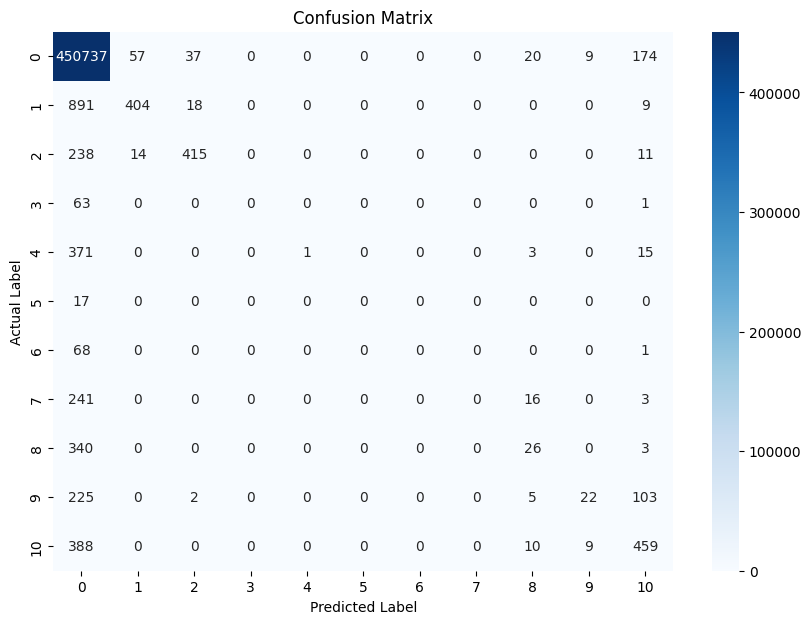

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and print the classification report to get detailed performance metrics
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Compute the confusion matrix to visualize the model's performance across different classes
cm = confusion_matrix(true_labels, predicted_labels)

# Set up the matplotlib figure and plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))  # Set the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')  # Draw the heatmap
plt.title("Confusion Matrix")  # Title of the plot
plt.ylabel("Actual Label")  # Y-axis label
plt.xlabel("Predicted Label")  # X-axis label
plt.show()  # Display the plot
